#  Replicating Hochberg book

In [1]:
import numpy as np
from matplotlib import pyplot as plt

import tidy3d as td
from generate_mesh import gen_mesh

import devsim as ds

In [2]:
# convert size into cm
um_to_cm = 1e-4

w_core = 0.25 * um_to_cm
h_core = 0.22 * um_to_cm
#w_clearance = 0.5 * um_to_cm
w_clearance = 2.25 * um_to_cm
h_clearance = 0.09 * um_to_cm
w_side = 2.5 * um_to_cm
h_side = 0.22 * um_to_cm

w_contact = 1.2 * um_to_cm
h_contact = 0.2 * um_to_cm

z_size = h_clearance/5

res = h_clearance/10

# modulator doping concentrations (1/cm^3)
conc_p = 7e17 + 1e15
conc_n = 5e17

conc_contact = 5e18

In [3]:
eps_Si = 11.7

Si_p = td.Medium(
    electric_spec=td.SemiConductorSpec(
        conductivity=1,
        permittivity=eps_Si,
        donors=0,
        acceptors=conc_p,
    ),
    name="Si_p",
)

Si_ppp = td.Medium(
    electric_spec=td.SemiConductorSpec(
        conductivity=1,
        permittivity=eps_Si,
        donors=0,
        acceptors=conc_contact,
    ),
    name="Si_ppp",
)

Si_n = td.Medium(
    electric_spec=td.SemiConductorSpec(
        conductivity=1,
        permittivity=eps_Si,
        donors=conc_n,
        acceptors=1e15,
    ),
    name="Si_n",
)

Si_nnn = td.Medium(
    electric_spec=td.SemiConductorSpec(
        conductivity=1,
        permittivity=eps_Si,
        donors=conc_contact,
        acceptors=1e15,
    ),
    name="Si_nnn",
)


aux_left = td.Medium(
    heat_spec=td.FluidSpec(),
    name="aux_left"
)

aux_right = td.Medium(
    heat_spec=td.FluidSpec(),
    name="aux_right"
)

air = td.Medium(heat_spec=td.FluidSpec(), name="air")

Current acceptor:  7.01e+17
Current donor:  0.0
Current acceptor:  5e+18
Current donor:  0.0
Current acceptor:  1000000000000000.0
Current donor:  5e+17
Current acceptor:  1000000000000000.0
Current donor:  5e+18


In [4]:
# create objects
overlap_factor = 1.0001

core_p = td.Structure(
    geometry=td.Box(center=(-w_core/2, h_core/2, 0), size=(w_core, h_core, z_size)),
    medium=Si_p,
    name="core_p"
)

core_n = td.Structure(
    geometry=td.Box(center=(w_core/2, h_core/2, 0), size=(w_core, h_core, z_size)),
    medium=Si_n,
    name="core_n"
)

clearance_p = td.Structure(
    geometry=td.Box(center=(-w_core - w_clearance/2, h_clearance/2, 0), size=(w_clearance, h_clearance, z_size)),
    medium=Si_p,
    name="clearance_p"
)

clearance_n = td.Structure(
    geometry=td.Box(center=(w_core + w_clearance/2, h_clearance/2, 0), size=(w_clearance, h_clearance, z_size)),
    medium=Si_n,
    name="clearance_n"
)

side_p = td.Structure(
    geometry=td.Box(center=(-w_core - w_clearance - w_side/2, h_side/2, 0), size=(w_side, h_side, z_size)),
    medium=Si_ppp,
    name="side_p"
)

side_n = td.Structure(
    geometry=td.Box(center=(w_core + w_clearance + w_side/2, h_side/2, 0), size=(w_side, h_side, z_size)),
    medium=Si_nnn,
    name="side_n"
)

# create a couple structs to define the contacts
contact_left = td.Structure(
    geometry=td.Box(center=(-w_core - w_clearance - w_side + w_contact/2, h_side + h_contact/2, 0), size=(w_contact, h_contact, z_size)),
    medium=aux_left,
    name="contact_left"
)

contact_right = td.Structure(
    geometry=td.Box(center=(w_core + w_clearance + w_side - w_contact/2, h_side + h_contact/2, 0), size=(w_contact, h_contact, z_size)),
    medium=aux_right,
    name="contact_right"
)

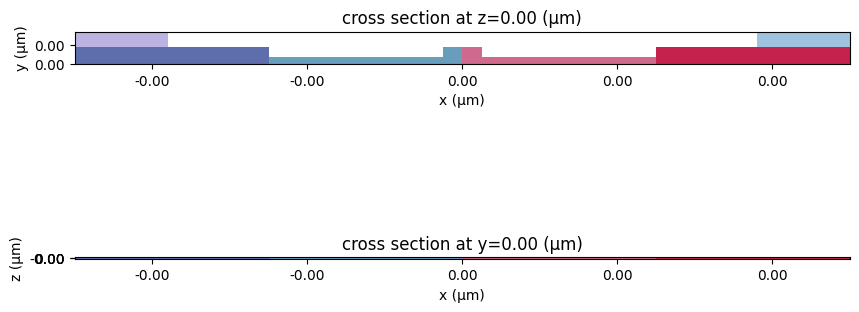

In [5]:
# create a scene with the previous structures
all_structures = [core_p, core_n, clearance_n, clearance_p, side_p, side_n, contact_left, contact_right]

scene = td.Scene(
    medium=air,
    structures=all_structures,
)


_, ax = plt.subplots(2, 1, figsize=(10, 5))

scene.plot(z=0, ax=ax[0])
scene.plot(y=5e-6, ax=ax[1])
plt.show()

In [6]:
# create BCs
voltages = list(np.linspace(-0.5, 4, 20))
bc_v1 = td.HeatChargeBoundarySpec(
    condition=td.VoltageBC(voltage=0),
    placement=td.MediumMediumInterface(mediums=[aux_left.name, Si_ppp.name]),
)

bc_v2 = td.HeatChargeBoundarySpec(
    condition=td.VoltageBC(voltage=voltages),
    placement=td.MediumMediumInterface(mediums=[aux_right.name, Si_nnn.name]),
)

boundary_conditions = [bc_v1, bc_v2]

In [7]:
# monitors
charge_mnt_3D = td.ChargeSimulationMonitor(
    center=(0, 0, 0), size=(0.6, 0.22, td.inf), name="charge_3D_mnt", unstructured=True
)

charge_mnt_2D = td.ChargeSimulationMonitor(
    center=(0, 0, 0), size=(0.6, 0.22, 0), name="charge_z0", unstructured=True
)

In [8]:
# devsim setting 
from tidy3d import DevsimConvergenceSettings
convergence_settings = DevsimConvergenceSettings(relTol=1e5, absTol=1e3, maxIters=400, dV=0.3)

In [9]:
# mesh
mesh = td.DistanceUnstructuredGrid(dl_interface=res*0.75, dl_bulk=res*1.95, distance_interface=2*h_side,
                                  distance_bulk=2*h_side, relative_min_dl=0,
                                  non_refined_structures=[clearance_n.name, clearance_p.name, side_p.name, side_n.name]
                                  )

# build heat simulation object
heat_sim = td.HeatChargeSimulation(
    sources=[],
    monitors=[charge_mnt_3D, charge_mnt_2D],
    devsim_settings=[convergence_settings],
    center=(0,0,0),
    size=(5,5,5),
    structures=all_structures,
    medium=air,
    boundary_spec=boundary_conditions,
    grid_spec=mesh,
    symmetry=(0, 0, 0)
    )

### Run pipeline

In [10]:
%matplotlib inline
#heat_sim_data = gen_mesh(heat_sim)
from run_drift import run_drift
devsim_data = run_drift(heat_sim)

[24-10-15 17:18:34.902][DEBUG  ]: Remote run: False
[24-10-15 17:18:34.902][DEBUG  ]: Listing client arguments: 
[24-10-15 17:18:34.902][DEBUG  ]:    checkEstimateUri: 
[24-10-15 17:18:34.902][DEBUG  ]:    estWorkUnitFile: ./tmp/est_work_unit.json
[24-10-15 17:18:34.902][DEBUG  ]:    ignoreError: false
[24-10-15 17:18:34.902][DEBUG  ]:    validateOnly: false
[24-10-15 17:18:34.902][DEBUG  ]:    resourceId: tmp
[24-10-15 17:18:34.902][DEBUG  ]:    releasePath: /home/marc/Documents/src/tidy3d-core/_build_release
[24-10-15 17:18:34.902][DEBUG  ]:    fileSystem: distributed
[24-10-15 17:18:34.902][SUPPORT]: Starting tidy3dHeatMetaDataPipeline for task id tmp
[24-10-15 17:18:34.902][DEBUG  ]: Starting heavy imports
[24-10-15 17:18:34.902][SUPPORT]: Using 'simulation.hdf5' file found in folder.
[24-10-15 17:18:34.903][DEBUG  ]: Done with heavy imports
Current acceptor:  7.01e+17
Current donor:  0.0
Current acceptor:  1000000000000000.0
Current donor:  5e+17
Current acceptor:  100000000000000

Traceback (most recent call last):
  File "/home/marc/Documents/src/tidy3d-core/_build_release/bin/denormalize.py", line 32, in <module>
    denormalize(simfile, save_dir)
  File "/home/marc/Documents/tidy3D_python/tidy3d_local/lib/python3.12/site-packages/tidy3d_denormalizer/denormalizer.py", line 207, in denormalize
    denormalize_directly(sim_data=sim_data, base_dir=base_dir)
                                  ^^^^^^^^
UnboundLocalError: cannot access local variable 'sim_data' where it is not associated with a value
Traceback (most recent call last):
  File "/home/marc/Documents/src/tidy3d-core/_build_release/bin/flow360runner.py", line 36, in <module>
    subprocess.check_call([sys.executable, '-u'] + args)
  File "/usr/lib/python3.12/subprocess.py", line 413, in check_call
    raise CalledProcessError(retcode, cmd)
subprocess.CalledProcessError: Command '['/home/marc/Documents/tidy3D_python/tidy3d_local/bin/python3', '-u', '/home/marc/Documents/src/tidy3d-core/_build_release/bin/d

Current acceptor:  7.01e+17
Current donor:  0.0
Current acceptor:  1000000000000000.0
Current donor:  5e+17
Current acceptor:  1000000000000000.0
Current donor:  5e+17
Current acceptor:  7.01e+17
Current donor:  0.0
Current acceptor:  5e+18
Current donor:  0.0
Current acceptor:  1000000000000000.0
Current donor:  5e+18


17:24:20 CEST WARNING: Could not execute validator 'warn_no_data' because field 
              'monitor' failed validation.                                      

              WARNING: Could not execute validator 'warn_no_data' because field 
              'monitor' failed validation.                                      

### Post-process data

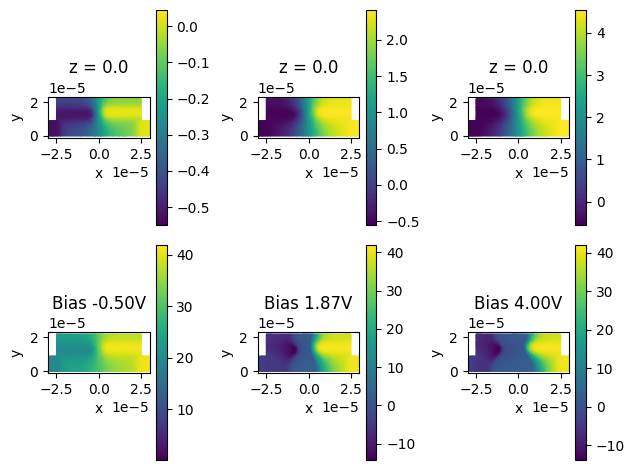

In [11]:
indices = [0]
indices.append(int(np.ceil(devsim_data[charge_mnt_2D.name].data_series.num_fields_saved/2)))
indices.append(int(np.ceil(devsim_data[charge_mnt_2D.name].data_series.num_fields_saved-1)))

series = devsim_data[charge_mnt_2D.name].data_series
sets_to_plot = [[], []]
if series.num_fields_saved > 2:
    fig, ax = plt.subplots(2, 3)
    for n, index in enumerate(indices):
        sets_to_plot[0].append(
            series.get_field("Potential", index)
        )
        sets_to_plot[0][n].plot(ax=ax[0][n], grid=False)
        ax[0][n].set_xlim((-0.3e-4, 0.3e-4))
        sets_to_plot[1].append(
            np.log(series.get_field("Electrons", index))
        )
        sets_to_plot[1][n].plot(ax=ax[1][n], grid=False)
        ax[1][n].set_title("Bias {0:0.2f}V".format(series.parameter_array[index]))
        ax[1][n].set_xlim((-0.3e-4, 0.3e-4))

plt.tight_layout()

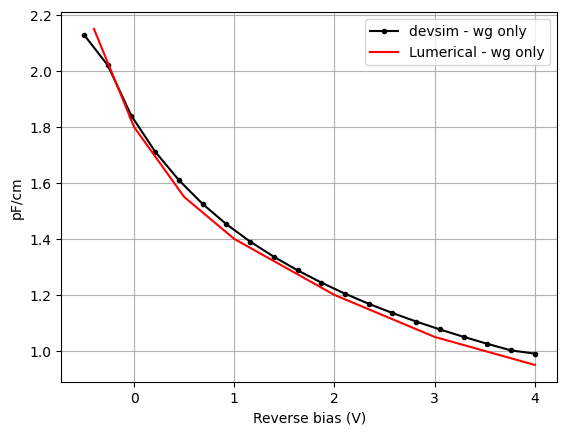

In [15]:
# capacitance from device
ce = np.array(devsim_data.device_characteristics["cv_curve_e"].data)
ch = np.array(devsim_data.device_characteristics["cv_curve_h"].data)
v = devsim_data.device_characteristics["cv_curve_e"].coords["Voltage (V)"].data

mnt_3D_ce = np.array(devsim_data[charge_mnt_3D.name].capacitance_curve["cv_curve_e"].data)
mnt_3D_ch = np.array(devsim_data[charge_mnt_3D.name].capacitance_curve["cv_curve_h"].data)
v_3D_mnt = np.array(devsim_data[charge_mnt_3D.name].capacitance_curve["cv_curve_h"].coords["Voltage (V)"].data)

c_wg_lumerical = np.array([0.215, 0.18, 0.155, 0.14, 0.12, 0.105, 0.095])
c_wg_lumerical_inAir = np.array([0.19, 0.155, 0.135, 0.12, 0.105, 0.091, 0.082])
v_data = [-0.4, 0.0,  0.5,  1.0,  2.0,  3.0,   4]
000000
#plt.plot(v, -0.5*(ce+ch)/z_size * 1e-3, "k.-", label="devsim - wg only" )
plt.plot(v_3D_mnt, -0.5*(mnt_3D_ce+mnt_3D_ch)/z_size * 1e-3, "k.-", label="devsim - wg only" )#
plt.plot(v_data, c_wg_lumerical*10, "r-", label="Lumerical - wg only")
plt.xlabel("Reverse0 bias (V)")
plt.ylabel("pF/cm")
plt.legend()
plt.grid()
plt.show()

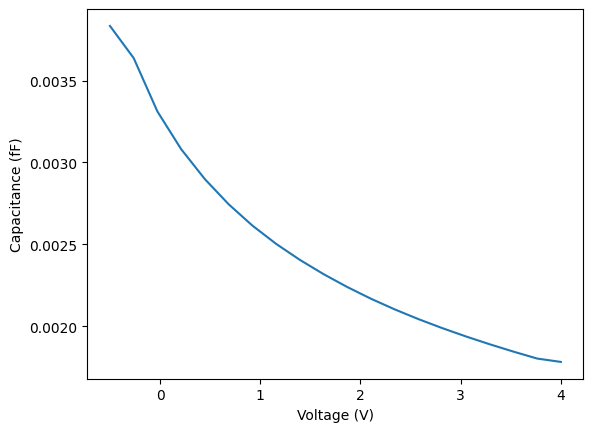

In [23]:
np.abs(devsim_data[charge_mnt_3D.name].capacitance_curve["cv_curve_h"]).plot()